In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

import pandas as pd

1 Physical GPUs, 1 Logical GPUs


In [2]:
from pde_solvers.cn import *
from local_utils import *
from turing.three_nodes_circuits import create_circuit_3954

# Load the parameters

In [3]:
df = pd.read_csv("../df_network_analysis.csv")
df["adj_tup"] = df["adj_tup"].apply(lambda x: eval(f"tuple({x})"))
df["Adj"] = df["adj_tup"].apply(lambda x: np.array(x).reshape((3,3)))

In [4]:
adj=np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
subnet_list = [g[1] for g in df.groupby("adj_tup") if g[0] == tuple(adj.flatten())]
if len(subnet_list) == 0:
    print("================================")
    print("There is no adjacancy matrix as: ", adj)
    print("================================")
else:
    subnet_df = subnet_list[0]

In [5]:
with open('../turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('../outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [6]:
subnet_df.head(1)

,min_A,min_B,min_C,avg_A,avg_B,avg_C,max_A,max_B,max_C,std_A,...,lb_CB,ub_CB,state_CC,lb_CC,ub_CC,Adj,k_max,params,path,adj_tup
116,0.879311,27.4671,2.00005,3.859942,31.707845,2.000238,6.759598,35.970982,2.000543,1.49011,...,1.780018,56.210562,Active,0.880009,28.110281,"[[1, 1, -1], [-1, 0, -1], [0, -1, 1]]",8.430177,[4.0e+00 1.0e-03 1.0e-01 5.0e+00 5.0e+00 5.0e+...,outputs_second_search/solution_10_0_24.npy,"(1, 1, -1, -1, 0, -1, 0, -1, 1)"


In [7]:
def load_dataset(path):
    with open(f"../{path}", "rb") as f:
        k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

In [10]:
def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)

def simulation(index, epochs=20000+1, epochs2=20000+1, epochs3=20000+1, scale=None, run="1"):
    print("######################################################")
    path = subnet_df["path"].iloc[index]
    print(index, path)
    (params, res, k_max) = load_dataset(path)
    plot_n_im([to(res[-1, 0, :]), to(res[-1, 1, :]), to(res[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
    
    T=1    
    L=10
    data = reshape(res, T)
    nodes_n = data.shape[0]
    node_names = ["A", "B", "C"]
    x_size = data.shape[1]
    y_size = data.shape[2]
    ##########################################
    # Create a mesh that is the centers of the
    # original mesh
    x_size -= 1
    y_size -= 1
    dxdy = L**2/((x_size-1)*(y_size-1))
    #####
    N = x_size*y_size    
    t_star = np.arange(T, T+1)

    ##########################
    # select a subset of data
    #t_star = t_star[-4:]
    #T = len(t_star)
    #data = data[:, :, :, -4::]


    x_slice = slice(65, 100, 1)
    y_slice = slice(65, 100, 1)


    x_range = L * np.linspace(0, 1, x_size)[x_slice]
    y_range = L * np.linspace(0, 1, y_size)[y_slice]

    block_x = x_range.shape[0]
    block_y = y_range.shape[0]

    x = tf.constant(x_range, dtype=tf.float32)
    y = tf.constant(y_range, dtype=tf.float32)


    # The order of the Y and X must be reversed,
    # since the chnages the value finds the derivatives
    #Y, X = tf.meshgrid(x, y)

    X, Y = tf.meshgrid(x, y)
    ts = tf.constant(t_star, dtype=tf.float32)
    T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
    def H_cube(X, Y, T):
        return tf.concat(
                [
                    tf.concat(
                        [
                            X[tf.newaxis, :, :, tf.newaxis],
                            Y[tf.newaxis, :, :, tf.newaxis],
                            T[:, :, i : i + 1][tf.newaxis, :, :, :],
                        ],
                        axis=3,
                    )
                    for i in range(T.shape[-1])
                ],
                axis=0,
            )
    H = H_cube(X, Y, T)

    ########################################
    # Take the average of data points
    kernel =np.array([[1, 1],
                      [1, 1]])


    data2 = np.stack([[ (ndimage.convolve(data[i, :, :, j], kernel)/4)[x_slice, y_slice] 
                            for j in  range(data.shape[3])]
                            for i in  range(data.shape[0])])
    data2 = np.einsum("ctxy -> cxyt", data2)

    ############################################ 
    plt.figure(figsize=(12, 3))
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.imshow(data[i, x_slice, y_slice, -1])
        plt.colorbar()
    plt.tight_layout();plt.show()
    
    plt.figure(figsize=(12, 3))
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.imshow(data2[i, :, :, -1])
        plt.colorbar()
    plt.tight_layout();plt.show()
    
    ############################################
    
    c = data2.copy()
    ################################
    # Add noise
    ampA = np.max(c[0, :,:,-1]) - np.min(c[0, :,:,-1])
    ampB = np.max(c[1, :,:,-1]) - np.min(c[1, :,:,-1])
    ampC = np.max(c[2, :,:,-1]) - np.min(c[2, :,:,-1])
    noise_level = 0.05
    print(f"noise level:{noise_level}, A amplitude:{ampA}, B amplitude:{ampB}, C amplitude:{ampC},")
    print(f"A noise std:{ampA*noise_level}, B noise std:{ampB*noise_level}, C noise std:{ampC*noise_level}.")
    np.random.seed(42)
    c[0, :,:,:] += np.random.normal(0,ampA*noise_level ,c[0, :,:,:].shape)
    c[1, :,:,:] += np.random.normal(0,ampB*noise_level ,c[1, :,:,:].shape)
    c[2, :,:,:] += np.random.normal(0,ampC*noise_level ,c[2, :,:,:].shape)
    ###################################
    def gen_series():    

        for i in range(H.shape[0]):        
            yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 

    ds = tf.data.Dataset.from_generator(gen_series,
                                        output_types=(tf.float32, tf.float32), 
                                        output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                       (c.shape[1],c.shape[2], c.shape[0])))
    
    
    ############################################################
    def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0.0, 1e10,)
    
    def clip_by_D_lb(z):
        return tf.clip_by_value(z, 0.001, 1e10,)
    
    class tf_param:
        def __init__(self, name, value=None, is_constant=True):
            self.name = name
            if value is None:
                self.value = params[name]
            else:
                self.value = value
            self.is_constant = is_constant    


    def create_pinn(layers=[3, 1024, 1024, 3],
                    learning_rate=1e-2,
                    w1=1, w2=1, w3=1, w4=1, w5=1,
                    D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                    b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                    V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                    mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                    K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                    K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                    K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                    n_val=tf_param("n")): 
        # Since there is just one time step, the lower bound is zero and the upper bound is one
        lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
        ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
        pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
        #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

        def create_tf_var(param, no_clip=False, D=False):
            print(f"{param.name}: {param.value}")
            if D:
                return tf.Variable(param.value,
                                   dtype=pinn.dtype,
                                   name=param.name,
                                   constraint=clip_by_D_lb)
            if no_clip:
                return tf.Variable(param.value,
                                   dtype=pinn.dtype,
                                   name=param.name)
            else:
                return tf.Variable(param.value,
                                   dtype=pinn.dtype,
                                   name=param.name,
                                   constraint=clip_by_value_zero_lb)

        D_A = create_tf_var(D_A_val)    
        D_B = create_tf_var(D_B_val)
        b_A = create_tf_var(b_A_val)#
        b_B = create_tf_var(b_B_val)#
        b_C = create_tf_var(b_C_val)#
        V_A = create_tf_var(V_A_val)
        V_B = create_tf_var(V_B_val)
        V_C = create_tf_var(V_C_val)
        mu_A = create_tf_var(mu_A_val)
        mu_B = create_tf_var(mu_B_val)
        mu_C = create_tf_var(mu_C_val)
        K_AA = create_tf_var(K_AA_val)
        K_AB = create_tf_var(K_AB_val)
        K_AC = create_tf_var(K_AC_val)
        K_BA = create_tf_var(K_BA_val)
        K_BC = create_tf_var(K_BC_val)
        K_CB = create_tf_var(K_CB_val)
        K_CC = create_tf_var(K_CC_val)
        n = create_tf_var(n_val)

        w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
        w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
        w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
        w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
        w5 = tf.Variable(w4,dtype=pinn.dtype,name="w5")

        def as_tuple(val, param):
            if val.is_constant:
                return ()
            else:
                return (param,)


        params_trainable =(
                          as_tuple(D_A_val, D_A)
                        + as_tuple(D_B_val, D_B)
                        + as_tuple(b_A_val, b_A)
                        + as_tuple(b_B_val, b_B)
                        + as_tuple(b_C_val, b_C)
                        + as_tuple(V_A_val, V_A)
                        + as_tuple(V_B_val, V_B)
                        + as_tuple(V_C_val, V_C)
                        + as_tuple(mu_A_val, mu_A)
                        + as_tuple(mu_B_val, mu_B)
                        + as_tuple(mu_C_val, mu_C)                    
                        + as_tuple(K_AA_val, K_AA)
                        + as_tuple(K_AB_val, K_AB)
                        + as_tuple(K_AC_val, K_AC)
                        + as_tuple(K_BA_val, K_BA)
                        + as_tuple(K_BC_val, K_BC)
                        + as_tuple(K_CB_val, K_CB)
                        + as_tuple(K_CC_val, K_CC)
                       )
        

        @tf.function
        def train_step_inverse(elements):
            def flatten(arr):
                return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))

            # Using VALID padding removes the boundaries
            #print(elements[1][..., 0:1].shape)
            act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
            #print(act_A_laplacian.shape)
            act_A_laplacian = flatten(act_A_laplacian)
            #print(act_A_laplacian.shape)
            act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
            act_B_laplacian = flatten(act_B_laplacian)

            act_A_rhs = tf.squeeze(act_A_laplacian/(dxdy))
            act_B_rhs = tf.squeeze(act_B_laplacian/(dxdy))

            def to(arr):            
                return arr.numpy().reshape(53, 53)


            with tf.GradientTape(persistent=True) as tape: 
                H = elements[0]
                # remove the boundaries
                H = H[:, 1:-1, 1:-1, :]
                H = flatten(H)
                tape.watch(H)
                trainables = pinn.trainable_variables + params_trainable

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])

                grad_A = tape.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]

                grad_B = tape.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


                grad_A_x = tape.gradient(A_x, H)
                A_xx = grad_A_x[:, 0]
                grad_A_y = tape.gradient(A_y, H)
                A_yy = grad_A_y[:, 1]
                grad_B_x = tape.gradient(B_x, H)
                B_xx = grad_B_x[:, 0]
                grad_B_y = tape.gradient(B_y, H)
                B_yy = grad_B_y[:, 1]

                H2 = elements[1]
                # remove the boundaries
                H2 = H2[:, 1:-1, 1:-1, :]
                H2 = flatten(H2)

                A = tf.squeeze(H2[:, 0])
                B = tf.squeeze(H2[:, 1])
                C = tf.squeeze(H2[:, 2])                

                def act(x, km, n=2):
                    return 1 / (1 + (km / (x + 1e-20)) ** (n))

                def inh(x, km, n=2):
                    return 1 / (1 + (x / (km + 1e-20)) ** (n))

                A_rhs =  (A_xx + A_yy)# - u_t
                B_rhs =  (B_xx + B_yy)# - v_t


                f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + D_A * A_rhs
                f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + D_B * B_rhs
                f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C

                l2_res_A = tf.reduce_mean(f_A**2)
                l2_res_B = tf.reduce_mean(f_B**2)
                l2_res_C = tf.reduce_mean(f_C**2)            

                l2_res_A_rhs = tf.reduce_mean((A_rhs-act_A_rhs)**2)
                l2_res_B_rhs = tf.reduce_mean((B_rhs-act_B_rhs)**2)


                l2 = (w1*l2_res_A + w2*l2_res_B + 
                      w3*l2_res_C +
                      w4*l2_res_A_rhs + w5*l2_res_B_rhs)

            grads = tape.gradient(l2, trainables)
            optimizer.apply_gradients(zip(grads, trainables))
            return (l2_res_A, l2_res_B, 
                    l2_res_C,  
                    l2_res_A_rhs, l2_res_B_rhs
            )

        names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
                'l2_res_A_rhs', 'l2_res_B_rhs']

        def print_callback(printer, losses, epoch):

            printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
            printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
            printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))

        return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
                w1, w2, w3, w4, w5)
    ############################################################
    if scale is None:
        (pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
            w1, w2, w3, w4, w5) = create_pinn(learning_rate=1e-2,
            D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
            b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                              b_C_val=tf_param("b_C", 1, False),
            V_A_val=tf_param("V_A", 1, False),V_B_val=tf_param("V_B", 1, False),
                                              V_C_val=tf_param("V_C", 1, False),
            K_AA_val=tf_param("K_AA", 1, False),K_AB_val=tf_param("K_AB", 1, False),
            K_AC_val=tf_param("K_AC", 1, False), K_BA_val=tf_param("K_BA", 1, False),
            K_BC_val=tf_param("K_BC", 1, False), K_CB_val=tf_param("K_CB", 1, False),
            K_CC_val=tf_param("K_CC", 1, False),       
            #mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
            w1=1, w2=1, w3=1, w4=100, w5=100
            )
    else:
        (pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
            w1, w2, w3, w4, w5) = create_pinn(learning_rate=1e-2,
            D_A_val=tf_param("D_A",params["D_A"]*scale , False), 
            D_B_val=tf_param("D_B",params["D_B"]*scale, False),
            b_A_val=tf_param("b_A",params["b_A"]*scale, False),
            b_B_val=tf_param("b_B",params["b_B"]*scale, False),
            b_C_val=tf_param("b_C",params["b_C"]*scale, False),
            V_A_val=tf_param("V_A",params["V_A"]*scale, False),
            V_B_val=tf_param("V_B",params["V_B"]*scale, False),
            V_C_val=tf_param("V_C",params["V_C"]*scale, False),
            K_AA_val=tf_param("K_AA",params["K_AA"]*scale, False),
            K_AB_val=tf_param("K_AB",params["K_AB"]*scale, False),
            K_AC_val=tf_param("K_AC",params["K_AC"]*scale, False), 
            K_BA_val=tf_param("K_BA",params["K_BA"]*scale, False),
            K_BC_val=tf_param("K_BC",params["K_BC"]*scale, False), 
            K_CB_val=tf_param("K_CB",params["K_CB"]*scale, False),
            K_CC_val=tf_param("K_CC",params["K_CC"]*scale, False),       
            #mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
            w1=1, w2=1, w3=1, w4=100, w5=100
            )
    ############################################################    
    params_est = np.zeros((epochs, len(params_trainable1)))
    def epoch_callback1(epoch, loss_samples, index):
        params_est[epoch, : ] = [item.numpy() for item in params_trainable1]
    
    params_est2 = np.zeros((epochs2, len(params_trainable1)))
    def epoch_callback2(epoch, loss_samples, index):
        params_est2[epoch, : ] = [item.numpy() for item in params_trainable1]
    
    params_est3 = np.zeros((epochs3, len(params_trainable1)))
    def epoch_callback3(epoch, loss_samples, index):
        params_est3[epoch, : ] = [item.numpy() for item in params_trainable1]
    ########################
    losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)
    optimizer1.lr.assign(1e-3)
    losses2 = tu.train(epochs=epochs2,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)
    optimizer1.lr.assign(1e-4)
    losses3 = tu.train(epochs=epochs3,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback3,
                  stop_condition=None)
    print("--------------------------------------")
    print(params)
    print("--------------------------------------")
    plt.plot(np.concatenate([losses1, losses2, losses3]))
    plt.yscale('log')
    plt.grid();plt.show()
    #############################################################
    (b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val,
     K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
     K_CB_val, K_CC_val ) = params_trainable1
    (n_val, D_A_val, D_B_val,
     b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
     K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
     K_CB_val, K_CC_val ) = (params["n"], params["D_A"], params["D_B"],
                             b_A_val, b_B_val, b_C_val,
                             V_A_val, V_B_val, V_C_val,
                             params["mu_A"], params["mu_B"], params["mu_C"],
                             K_AA_val, K_AB_val, K_AC_val, 
                             K_BA_val, K_BC_val, 
                             K_CB_val, K_CC_val)
    
    with open(f"../PINN_diffusion_outputs_second_search/full_subnets/parameters_{run}_{index}_no_diff.npy", "wb") as f:
        np.save(f, (L, n_val, D_A_val, D_B_val,
                b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
                K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
                K_CB_val, K_CC_val))
    with open(f"../PINN_diffusion_outputs_second_search/full_subnets/parameters_history_{run}_{index}_no_diff.npy", "wb") as f:
        np.save(f, np.concatenate([params_est, params_est2, params_est3]))
        
    pinn1.save(".", f"../PINN_diffusion_outputs_second_search/full_subnets/pinn_{run}_{index}_no_diff")
    with open(f"../PINN_diffusion_outputs_second_search/full_subnets/losses_{run}_{index}_no_diff.npy", "wb") as f:
        np.save(f, np.concatenate([losses1, losses2, losses3]))
    

######################################################
12 outputs_second_search/solution_10_10_103.npy


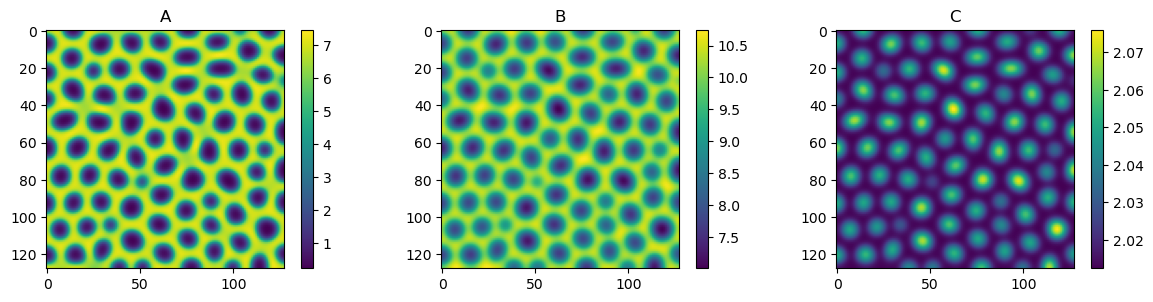

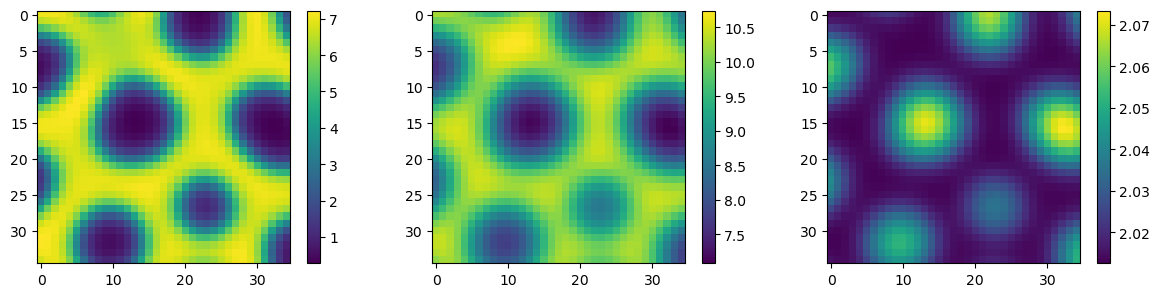

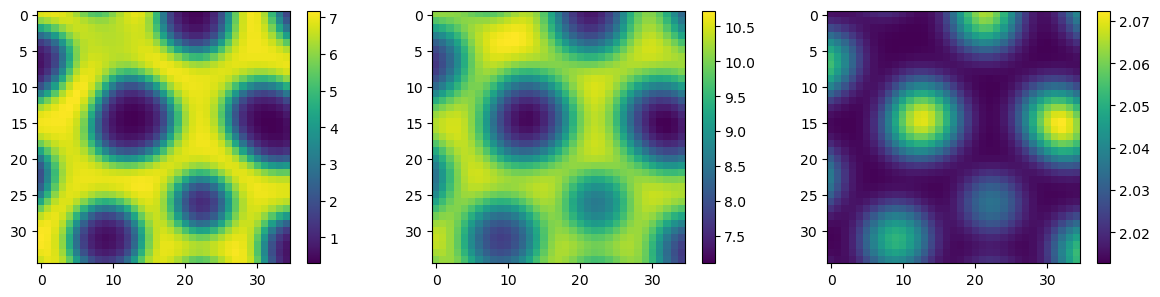

noise level:0.05, A amplitude:6.879837109261134, B amplitude:3.611657130733348, C amplitude:0.059708225847512786,
A noise std:0.3439918554630567, B noise std:0.1805828565366674, C noise std:0.0029854112923756396.
D_A: 0.01
D_B: 1.0
b_A: 1
b_B: 1
b_C: 1
V_A: 1
V_B: 1
V_C: 1
mu_A: 1.0
mu_B: 5.0
mu_C: 0.5
K_AA: 1
K_AB: 1
K_AC: 1
K_BA: 1
K_BC: 1
K_CB: 1
K_CC: 1
n: 4.0

Start of epoch 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
at epoch 0, total loss: 85866.52230546107
l2_res_A: 19.77698135, l2_res_B: 2155.40722656, l2_res_C: 0.00020692, l2_res_A_rhs: 66949.23437500, l2_res_B_rhs: 16742.10351562
b_A:0: 1.010000228881836, b_B:0: 1.010000228881836, b_C:0: 1.0099989175796509, V_A:0: 1.0099619626998901, V_B:0: 1.010000228881836, V_C:0: 1.0031026601791382, K_AA:0: 0.9920263886451721, K_AB:0: 0.9899998307228088, K_AC:0: 1.002600073814392, K


Start of epoch 13000
at epoch 13000, total loss: 18045.098380093354
l2_res_A: 5.20152617, l2_res_B: 15026.26367188, l2_res_C: 0.00000334, l2_res_A_rhs: 1701.42968750, l2_res_B_rhs: 1312.20349121
b_A:0: 0.20463518798351288, b_B:0: 27.55075454711914, b_C:0: 1.0044950246810913, V_A:0: 59.54307556152344, V_B:0: 46.50407028198242, V_C:0: 3.1352713108062744, K_AA:0: 6.803654193878174, K_AB:0: 0.0, K_AC:0: 6.362140655517578, K_BA:0: 7.861204147338867, K_BC:0: 3.6165409088134766, K_CB:0: 1.9627234935760498, K_CC:0: 3.168724536895752
Time taken: 33.82s

Start of epoch 14000
at epoch 14000, total loss: 17437.771104336836
l2_res_A: 5.41413689, l2_res_B: 16740.84179688, l2_res_C: 0.00000334, l2_res_A_rhs: 429.23928833, l2_res_B_rhs: 262.27587891
b_A:0: 0.24763700366020203, b_B:0: 25.764930725097656, b_C:0: 1.004465937614441, V_A:0: 63.32177734375, V_B:0: 51.95785903930664, V_C:0: 3.1582095623016357, K_AA:0: 7.006542682647705, K_AB:0: 0.0, K_AC:0: 6.381468296051025, K_BA:0: 7.8545098304748535, K_B


Start of epoch 8000
at epoch 8000, total loss: 16795.595227458572
l2_res_A: 5.39146805, l2_res_B: 16784.88867188, l2_res_C: 0.00000332, l2_res_A_rhs: 2.20079660, l2_res_B_rhs: 3.11428761
b_A:0: 0.25810351967811584, b_B:0: 4.563861846923828, b_C:0: 1.0040940046310425, V_A:0: 95.78153991699219, V_B:0: 96.4791488647461, V_C:0: 3.32625150680542, K_AA:0: 7.257513999938965, K_AB:0: 0.0, K_AC:0: 6.596916675567627, K_BA:0: 7.049259185791016, K_BC:0: 4.154562950134277, K_CB:0: 1.9386838674545288, K_CC:0: 3.7138311862945557
Time taken: 33.81s

Start of epoch 9000
at epoch 9000, total loss: 16821.646715143324
l2_res_A: 5.36427212, l2_res_B: 16809.35742188, l2_res_C: 0.00000332, l2_res_A_rhs: 3.28861570, l2_res_B_rhs: 3.63640213
b_A:0: 0.2584421634674072, b_B:0: 3.7061686515808105, b_C:0: 1.0041019916534424, V_A:0: 96.75736999511719, V_B:0: 97.4935302734375, V_C:0: 3.3369014263153076, K_AA:0: 7.262989521026611, K_AB:0: 0.0, K_AC:0: 6.615360736846924, K_BA:0: 7.031153202056885, K_BC:0: 4.184158325

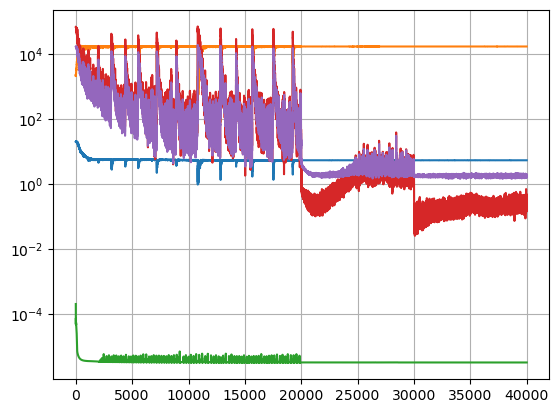

In [11]:
simulation(12, epochs=20000+1, epochs2=10000+1, epochs3=10000+1)

In [12]:
D_A_val, D_B_val = 0.01, 1.0
N=5000
T=100
delta_t = T/N
model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], delta_t=delta_t, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)

12 outputs_second_search/solution_10_10_103.npy
D_A:0.0100, D_B:1.0000, b_A:0.2588, mu_A:1.0000, V_A:98.7255, K_AA:7.2741, K_AB:0.0000, K_AC:6.6641, b_B:1.9065, mu_B:5.0000, V_B:99.4986, K_BA:6.9952, K_BC:4.2903, b_C:1.0040, mu_C:0.5000, V_C:3.3704, K_CB:1.9636, K_CC:3.8429


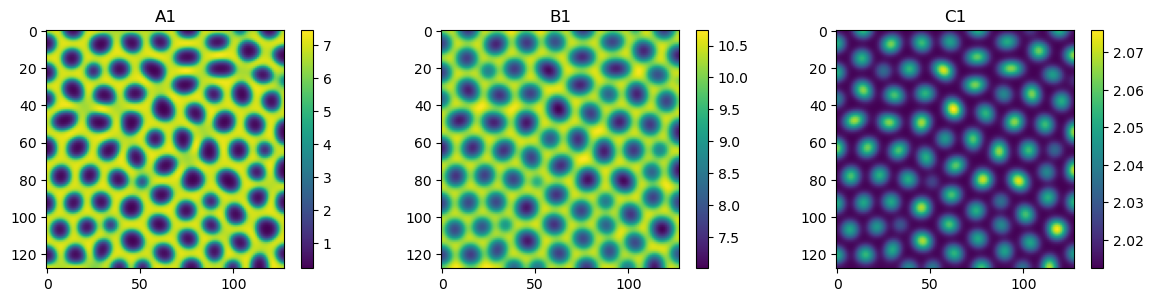

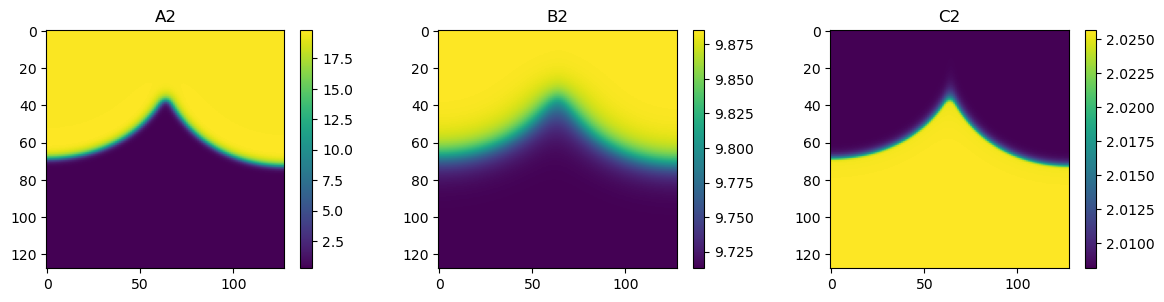

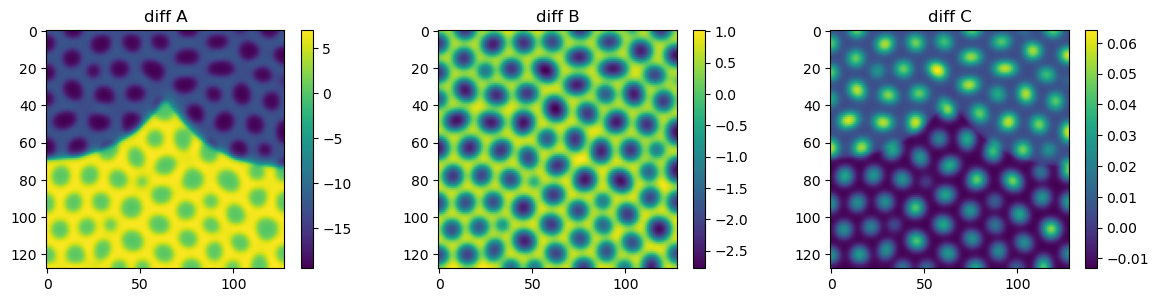

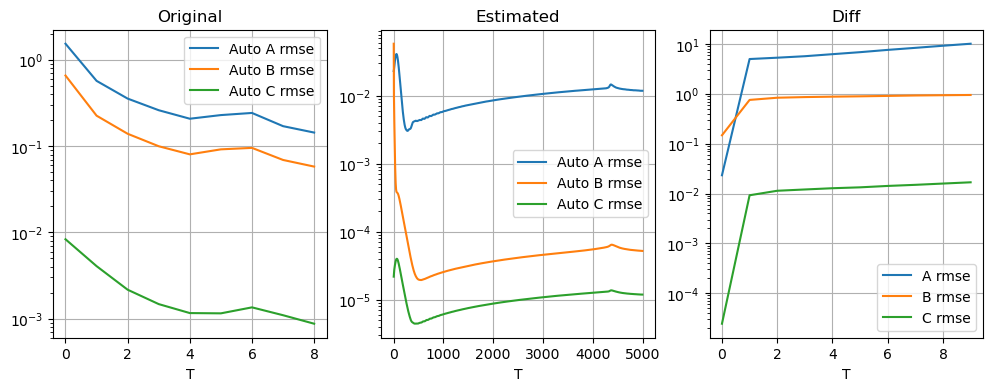

In [13]:
index = 12
path = subnet_df["path"].iloc[index]
print(index, path)
(params, res_1, k_max) = load_dataset(path)

n_val = params["n"]
mu_A_val, mu_B_val, mu_C_val = params["mu_A"], params["mu_B"], params["mu_C"]
b_A_val= 0.258791983127594
b_B_val= 1.9064775705337524
b_C_val= 1.003972053527832
V_A_val= 98.72554779052734
V_B_val= 99.49855041503906
V_C_val= 3.370405435562134
K_AA_val= 7.274129390716553
K_AB_val= 0.0
K_AC_val= 6.664134502410889
K_BA_val= 6.995151042938232
K_BC_val= 4.290341854095459
K_CB_val= 1.9636231660842896
K_CC_val= 3.8429222106933594

print(f"D_A:{D_A_val:.4f}, D_B:{D_B_val:.4f}, b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
      f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
      f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
      f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
      f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
      f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")
kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

A_init = res_1[0, 0, :]
B_init = res_1[0, 1, :]
C_init = res_1[0, 2, :]
res_2 = model_128_10.integrate([A_init,B_init,C_init], kinetics, 5000-1, 1)

A1 = res_1[-1, 0, :]
B1 = res_1[-1, 1, :]
C1 = res_1[-1, 2, :]
plot_n_im([to(A1), to(B1), to(C1)], 
              ["A1", "B1", "C1"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

A2 = res_2[-1, 0, :]
B2 = res_2[-1, 1, :]
C2 = res_2[-1, 2, :] 
plot_n_im([to(A2), to(B2), to(C2)], 
              ["A2", "B2", "C2"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
              ["diff A", "diff B", "diff C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
def RMSE(a1, a2):
    return np.sqrt(np.mean((a1-a2)**2, axis=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

plt.subplot(132)
plt.plot(RMSE(res_2[1:, 0, :], res_2[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_2[1:, 1, :], res_2[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_2[1:, 2, :], res_2[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

plt.subplot(133)
plt.plot(RMSE(res_1[:, 0, :], res_2[::500, 0, :]) , label="A rmse")
plt.plot(RMSE(res_1[:, 1, :], res_2[::500, 1, :]) , label="B rmse")
plt.plot(RMSE(res_1[:, 2, :], res_2[::500, 2, :]) , label="C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
plt.show()